# Did you get here from the link in my NDSEG application?

The code below is the most up-to-date, but if you'd like to see the codebase at the time I submitted, see here: https://github.com/ironak/worms/blob/9df75a5c954d898a09fcfc526f2c772a69c14e9b/model.ipynb

Feel free to email me at ronakr@utexas.edu if you have any questions!

In [1]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
from pandas import DataFrame
import matplotlib
from matplotlib import pyplot as plt
import json

from numpy.lib.stride_tricks import sliding_window_view
from opt_einsum import contract
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

## Functions

### Build Connectome DiGraph

In [2]:
def get_connectome(filepath, sheet_name, existing_connectome=None):
    excel_connectome = pd.read_excel(filepath, sheet_name)
    table = excel_connectome.values[1:,2:]

    neuron_names = set().union(table[1:,0], table[0,1:])
    neuron_names = {x for x in neuron_names if x == x} #remove nans
    neuron_names = sorted(list(neuron_names))

    edge_list = []

    def isnan(x):
        return isinstance(x, float) and np.isnan(x)

    for r in range(1,len(table)):
        for c in range(1,len(table[r])):
            if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
                continue
            edge_list.append((table[r][0], table[0][c], table[r][c]))

    connectome = existing_connectome if existing_connectome else nx.DiGraph() 
    connectome.add_nodes_from(neuron_names)
    connectome.add_weighted_edges_from(edge_list)
    return connectome

In [3]:
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")

# just take the union of all connectome data
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn symmetric", existing_connectome=CONNECTOME)
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male gap jn asymmetric", existing_connectome=CONNECTOME)

In [4]:
print(sorted(((d,n) for n,d in CONNECTOME.degree), reverse=True))

[(138, 'AVAR'), (137, 'hyp'), (132, 'AVAL'), (110, 'AVBR'), (109, 'PVV'), (106, 'EF2'), (104, 'PDB'), (100, 'PVZ'), (96, 'EF3'), (94, 'AVG'), (93, 'PVX'), (91, 'PVNL'), (90, 'AVBL'), (85, 'DVA'), (83, 'EF1'), (83, 'CA05'), (80, 'PVCR'), (78, 'HOB'), (76, 'R7BL'), (74, 'VA12'), (74, 'R1BR'), (71, 'R3BR'), (70, 'DVC'), (70, 'AVFL'), (69, 'PVCL'), (68, 'PVY'), (67, 'PVPL'), (67, 'AVFR'), (66, 'VB09'), (66, 'PQR'), (66, 'CP07'), (66, 'CP04'), (65, 'PVNR'), (65, 'CP05'), (65, 'CA06'), (65, 'AVKR'), (64, 'VB08'), (64, 'R7BR'), (64, 'HOA'), (64, 'CP09'), (64, 'AVKL'), (62, 'VB10'), (62, 'R2BR'), (61, 'PHCL'), (60, 'SPVL'), (60, 'AVDR'), (59, 'SPVR'), (59, 'R2BL'), (59, 'DVF'), (59, 'DD05'), (58, 'DD06'), (57, 'R7AR'), (57, 'R3BL'), (57, 'PHCR'), (57, 'PCAL'), (56, 'RIBR'), (56, 'R9AR'), (55, 'R5BR'), (55, 'PCBL'), (54, 'SMDVL'), (54, 'RIAR'), (54, 'PDC'), (54, 'CP06'), (53, 'SMDDL'), (53, 'RIAL'), (53, 'AVL'), (53, 'AVDL'), (52, 'R7AL'), (52, 'DA08'), (51, 'VA10'), (51, 'SMDDR'), (51, 'PVQR')

In [5]:
# nx.draw_networkx(CONNECTOME, arrows=True)

In [6]:
fake_connectome = get_connectome('datasets/fake_test_data/fake_connectome.xlsx', 'S1S2N1')

In [7]:
def get_weight(neuron1, neuron2, connectome=CONNECTOME):
    return connectome.get_edge_data(neuron1, neuron2)['weight'] if connectome.get_edge_data(neuron1, neuron2) else 0

In [8]:
class TraceObject:
    def __init__(self, json_filepath):
        with open(json_filepath) as trace_file:
            self.trace_json = json.load(trace_file)

        self.uid = self.trace_json['uid']
        self.num_neurons = self.trace_json['num_neurons']
        self.traces = np.array(self.trace_json['trace_array'])

        self.trace_indices = {}
        for i in range(self.trace_json['num_neurons']):
            if str(i+1) in self.trace_json['labeled']:
                self.trace_indices[self.trace_json['labeled'][str(i+1)]['label']] = i  # neurons are 1-indexed

    def get_label(self, i):
        if str(i+1) not in self.trace_json['labeled']:
            return "" # empty string indicates neuron at index i is unlabeled
        return self.trace_json['labeled'][str(i+1)]['label']
    
    def get_index(self, label):
        if label not in self.trace_indices:
            return -1
        return self.trace_indices[label]
        

In [9]:
def get_relevant_neurons(neuron, connectome=CONNECTOME):
    return set().union(connectome.predecessors(neuron), connectome.successors(neuron)) #[neuron], 

def get_relevant_mask(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = get_relevant_neurons(neuron, connectome)
    return np.array([trace_obj.get_label(i) in relevant_neurons for i in range(trace_obj.num_neurons)])

def get_relevant_mask_labels(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = get_relevant_neurons(neuron, connectome)
    indices = []
    for i in range(trace_obj.num_neurons):
        label = trace_obj.get_label(i)
        if label in relevant_neurons:
            indices.append(label)
    return indices

In [10]:
def get_connected_component(neuron, trace_obj, connectome=CONNECTOME):
    pre = set()
    s = set(get_relevant_mask_labels(neuron, trace_obj, connectome))
    diff = s - pre 
    while len(diff) != 0:
        pre = s.copy()
        for new_neuron in diff:
            adj = get_relevant_mask_labels(new_neuron, trace_obj, connectome)
            # print(new_neuron, adj)
            s.update(adj)
        diff = s - pre
        # print(s)
        # print(pre)
        # print(diff)
    return s

In [11]:
trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
s = get_connected_component('AVAL', trace_obj)
print(len(s))

94


In [12]:
s = set().union([1,2,3])
s = s.union([2,3,4])
print(s)

{1, 2, 3, 4}


In [13]:
print(get_relevant_neurons("AVAR"))

{'PVCR', 'AVER', 'PLML', 'RICL', 'RIML', 'DB02', 'AS10', 'CEPDL', 'RICR', 'URXR', 'DB06', 'DB03', 'VA08', 'R5BR', 'DA02', 'LUAL', 'CP05', 'AS05', 'AS01', 'R5AR', 'VA10', 'DA05', 'PLMR', 'FLPL', 'VA02', 'VA05', 'VB09', 'R3AL', 'URYDR', 'PVV', 'R1AL', 'DVA', 'VA12', 'AS11', 'DA04', 'LUAR', 'AVFL', 'VA03', 'RIGL', 'PQR', 'VA11', 'PVCL', 'VB08', 'DA08', 'VA09', 'DA01', 'AVBL', 'AVEL', 'VA01', 'VB06', 'RIGR', 'AS06', 'FLPR', 'R1BR', 'ALNL', 'PVDL', 'AS08', 'PVNL', 'VA07', 'VB10', 'AVDR', 'R3AR', 'AQR', 'hyp', 'SABVR', 'PVPL', 'VA06', 'AS04', 'CEMDR', 'ADEL', 'AS07', 'AS09', 'DA06', 'VA04', 'CEPVL', 'AVAL', 'PVDR', 'AVFR', 'AVDL', 'SMDVR', 'SIBDL', 'AS02', 'DA03', 'DA07', 'DA09', 'AVKL', 'PVX', 'SAAVR', 'DVC'}


In [14]:
W_rr = 3
W_sr = 1

In [15]:
def plot_trace(data, title=None, xlabel="Time (steps of 0.6s)", ylabel="Calcium Level (z-scored)"):
    DataFrame(data).plot(
        title=title, 
        xlabel=xlabel, 
        ylabel=ylabel,
        legend=False)
    # hacky autoticker
    # appx_num_ticks = 8
    # tick_scale = 5 * 10**(round(np.log10(len(data)))-2)
    # tick_step = tick_scale * round(len(data)/(appx_num_ticks*tick_scale))
    # plt.xticks(np.arange(0, len(data) + tick_step, tick_step), np.arange(start, start + len(data) + tick_step, tick_step))
    plt.show()

In [57]:
def calculate_c(neuron, trace_obj, window_start=0, window_width=None, w_rr=W_rr, w_sr=W_sr, connectome=CONNECTOME, plot=True):
    if window_width == None:
        window_width = trace_obj.traces.shape[1] - window_start
    num_windows = window_width - max(w_rr,w_sr) + 1

    traces = trace_obj.traces[:,window_start : window_start + window_width]
    
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    if self_index == -1:
        raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

    # TODO: We incur a T x relevant_count x w_rr x 1 x (w_sr+1) (about 3000x) blowup here - there is a LOT of redundancy that might be used to bring this down.
    # relevant_count x w_rr x 1 x (w_sr+1) (about 3000) is the number of entries in C
    relevant_sliding_window = np.squeeze(sliding_window_view(traces[relevant_mask,max(w_sr-w_rr,0):], (relevant_count, w_rr), writeable=False), axis=0)
    self_sliding_window = np.squeeze(sliding_window_view(traces[self_index:self_index+1,max(w_rr-w_sr,0):], (1, w_sr), writeable=False), axis=0)
    self_sliding_window = np.concatenate((self_sliding_window, np.ones((num_windows, 1, 1))), axis=2)
    A = contract("tij,tkl->tijkl", relevant_sliding_window, self_sliding_window).reshape(num_windows, relevant_count * w_rr * (w_sr + 1))
    A = A[:-1,:] # can't predict outside of observation window

    # Looking to minimize Ac - traces[neuron]
    observation = traces[self_index][max(w_rr,w_sr):]
    c, residuals, rank, singular_values = np.linalg.lstsq(A, observation, rcond=-1) # Formula: np.linalg.inv(A.T @ A) @ A.T @ observation
    prediction = A @ c
    
    rmse = np.sqrt(mean_squared_error(observation, prediction))
    explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)

    if plot:
        # plot_trace(observation, title=f"{neuron} Calcium Trace ({trace_obj.uid})")
        # plot_trace(prediction, title=f"Model Fit for {neuron} Trace ({trace_obj.uid})")
        # plot_trace(residuals,  title="Training Residuals", ylabel="Residual")
        print(f"(calculate_c) RMSE: {rmse} explained variance: {explained_variance}")

    return c

In [24]:
def live_simulation(c, neuron, trace_obj, start=None, runtime=None, w_rr=W_rr, w_sr=W_sr, connectome=CONNECTOME, plot=True):
    trace_len = trace_obj.traces.shape[1]
    if start == None or start < max(w_rr, w_sr):
        start = max(w_rr, w_sr)
    if runtime == None or start + runtime > trace_len:
        runtime = trace_len - start

    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    temp_traces = np.copy(trace_obj.traces) # we will overwrite the self_index row with our predicted values
    
    C = c.reshape((relevant_count,w_rr,1,w_sr+1))

    for t in range(start,start+runtime):
        relevant_history = temp_traces[relevant_mask,t-w_rr:t]
        self_history = temp_traces[self_index:self_index+1,t-w_sr:t]
        augmented_self_history = np.concatenate((self_history, np.ones((1,1))), axis=1)
        temp_traces[self_index, t] = contract("ij,ijkl,kl", relevant_history, C, augmented_self_history)

    observation = trace_obj.traces[self_index,start:start+runtime]
    prediction = temp_traces[self_index,start:start+runtime]
    residuals = observation - prediction
    
    rmse = np.sqrt(mean_squared_error(observation, prediction))
    explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)
    
    if plot:
        plot_trace(observation, title=f"{neuron} Calcium Trace ({trace_obj.uid})")
        plot_trace(prediction, title=f"Predicted {neuron} Calcium Trace ({trace_obj.uid})")
        plot_trace(residuals,  title="Residuals", ylabel="Residual")

        print(f"(live_simulation) RMSE: {rmse} explained variance: {explained_variance}")

    return explained_variance

In [25]:
class NeuronParam:
    def __init__(self, label, w_rr, w_sr, c, trace_obj, connectome=CONNECTOME):
        self.label = label
        self.w_rr = w_rr
        self.w_sr = w_sr
        self.c = c
        # self.trace_obj = trace_obj
        # self.connectome = connectome

        self.relevant_mask = get_relevant_mask(label, trace_obj, connectome)
        self.relevant_count = np.count_nonzero(self.relevant_mask)
        self.index = trace_obj.get_index(label)

        self.C = c.reshape((self.relevant_count,w_rr,1,w_sr+1))

    def update(self, traces, t):
        relevant_history = traces[self.relevant_mask, t-self.w_rr:t]
        self_history = traces[self.index:self.index+1, t-self.w_sr:t]
        augmented_self_history = np.concatenate((self_history, np.ones((1,1))), axis=1)
        traces[self.index, t] = contract("ij,ijkl,kl", relevant_history, self.C, augmented_self_history)

In [26]:
def live_simulations(neurons, trace_obj, start=None, runtime=None, connectome=CONNECTOME, plot=True):
    '''neurons : list(NeuronParam)'''
    max_retention = max([max(neuron.w_rr, neuron.w_sr) for neuron in neurons])
    trace_len = trace_obj.traces.shape[1]
    if start == None or start < max_retention:
        start = max_retention
    if runtime == None or start + runtime > trace_len:
        runtime = trace_len - start

    temp_traces = np.copy(trace_obj.traces) # we will overwrite the self_index row with our predicted values
    
    for t in range(start,start+runtime):
        for neuron in neurons:
            neuron.update(temp_traces, t)

    neuron_indices = [neuron.index for neuron in neurons]
    observation = trace_obj.traces[neuron_indices,start:start+runtime]
    prediction = temp_traces[neuron_indices,start:start+runtime]
    
    rmse = np.sqrt(mean_squared_error(observation, prediction))
    explained_variance = 1 - (mean_squared_error(observation, prediction))/np.var(observation)
    
    if plot:
        for i, neuron in enumerate(neurons):
            plot_trace(observation[i,:], title=f"{neuron.label} Calcium Trace ({trace_obj.uid})")
            plot_trace(prediction[i,:], title=f"Predicted {neuron.label} Calcium Trace ({trace_obj.uid})")
            plot_trace(observation[i,:] - prediction[i,:],  title="Residuals", ylabel="Residual")

        print(f"(live_simulations) RMSE: {rmse} explained variance: {explained_variance}")

    return explained_variance

In [27]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90)

    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    # ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [28]:
def visualize_c(c, neuron, trace_obj, w_rr=W_rr, w_sr=W_sr, connectome=CONNECTOME):
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)

    relevant_labels = get_relevant_mask_labels(neuron, trace_obj, connectome)
    if neuron in relevant_labels:
        i = relevant_labels.index(neuron)
        relevant_labels[i] = f'$\\bf{{{relevant_labels[i]}}}$'

    figure, ax = plt.subplots(1, 2)

    in_weights = np.array([[get_weight(neighbor, neuron) for neighbor in relevant_labels]]).T
    im, cbar = heatmap(in_weights, relevant_labels, [f'{neuron} (in)'], ax[0], cmap=plt.cm.Reds, cbarlabel='Connection Strength')
    texts = annotate_heatmap(im, valfmt='{x}', size=7)

    out_weights = np.array([[get_weight(neuron, neighbor) for neighbor in relevant_labels]]).T
    im, cbar = heatmap(out_weights, relevant_labels, [f'{neuron} (out)'], ax[1], cmap=plt.cm.Blues, cbarlabel='Connection Strength')
    texts = annotate_heatmap(im, valfmt='{x}', size=7)

    figure.show()

    C = c.reshape((relevant_count,w_rr,1,w_sr+1))
    figure, ax = plt.subplots(1, w_sr+1) 
    biggest = max(abs(np.max(C)), abs(np.min(C)))
    norm = matplotlib.colors.Normalize(vmin=-biggest, vmax=biggest)
    for i in range(w_sr+1):
        temp_ax = (ax if w_sr == 0 else ax[i])
        print(C[:,:,0,i])
        temp_ax.matshow(C[:,:,0,i], norm=norm, cmap=plt.cm.coolwarm)
        temp_ax.set_yticks(np.arange(relevant_count), relevant_labels)
        temp_ax.set_xticks(np.arange(w_rr), np.arange(w_rr,0,-1))
    figure.show()

## Tests

### Fake Tests

(calculate_c) RMSE: 1.885455802218072e-15 explained variance: 1.0


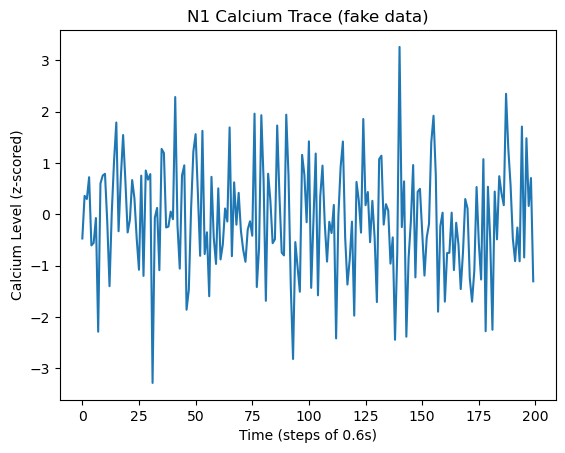

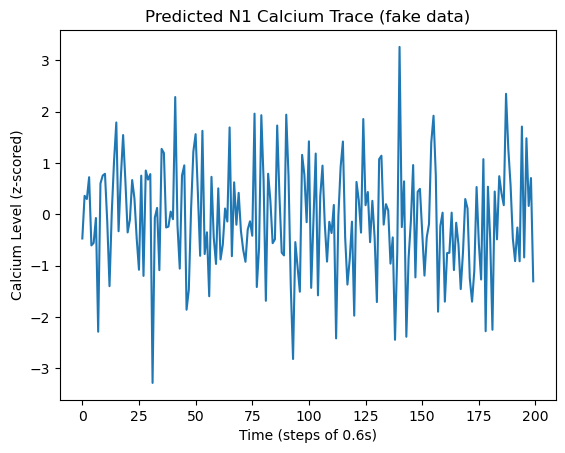

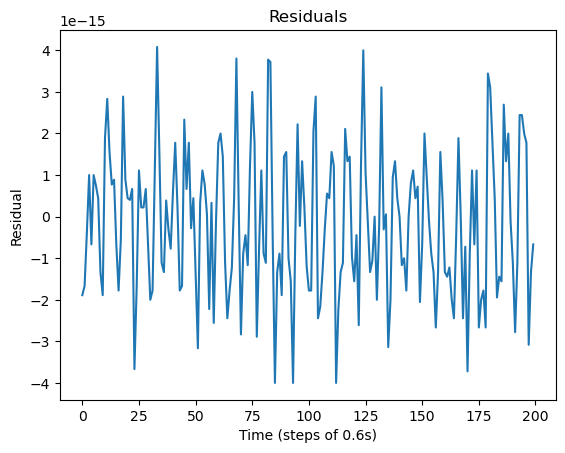

(live_simulation) RMSE: 1.741430343799485e-15 explained variance: 1.0
[[ 1.16211990e-16  1.00000000e+00 -1.36569031e-16  9.62723662e-17
  -2.04988610e-16 -6.99925506e-17 -1.39633987e-16 -1.36475466e-16
  -3.72220625e-16 -8.21767116e-16  4.46129937e-16  2.30047477e-16]
 [ 6.21220270e-03 -4.40877286e-03 -2.22668049e-03  3.79127148e-03
  -2.36810790e-03  2.73878523e-04  3.13821456e-03 -1.63422673e-03
   5.26149547e-03  7.65854085e-03  9.95689837e-01  9.32078234e-03]]


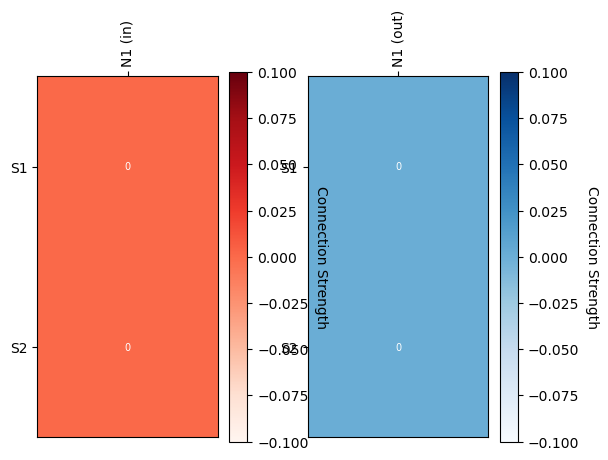

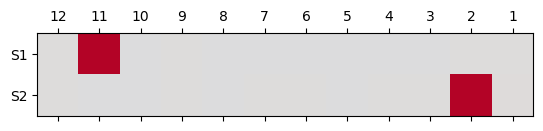

In [53]:
fake_trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
fake_w_rr = 12
fake_w_sr = 0
c = calculate_c('N1', fake_trace_obj, w_rr=fake_w_rr, w_sr=fake_w_sr, connectome=fake_connectome, window_start=0, window_width=500)
live_simulation(c, 'N1', fake_trace_obj, w_rr=fake_w_rr, w_sr=fake_w_sr, connectome=fake_connectome, start=1000, runtime=200)
visualize_c(c,'N1',fake_trace_obj, w_rr=fake_w_rr, w_sr=fake_w_sr, connectome=fake_connectome)

### Real Tests

#### AVAR fit

1 timestep = 0.6015548991234344 seconds


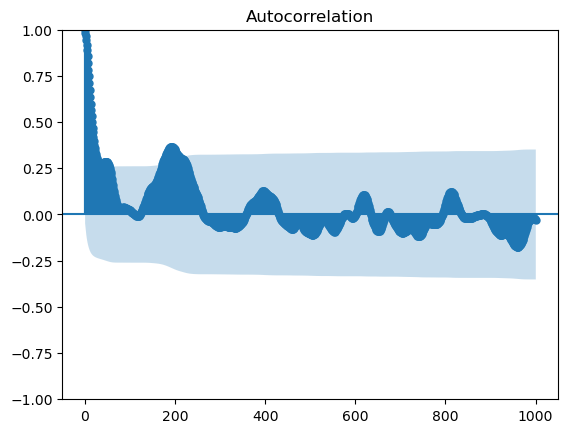

(calculate_c) RMSE: 0.16494294997036654 explained variance: 0.9804599687458282


/tmp/ipykernel_2589113/2641121574.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c, residuals, rank, singular_values = np.linalg.lstsq(A, observation) # Formula: np.linalg.inv(A.T @ A) @ A.T @ observation


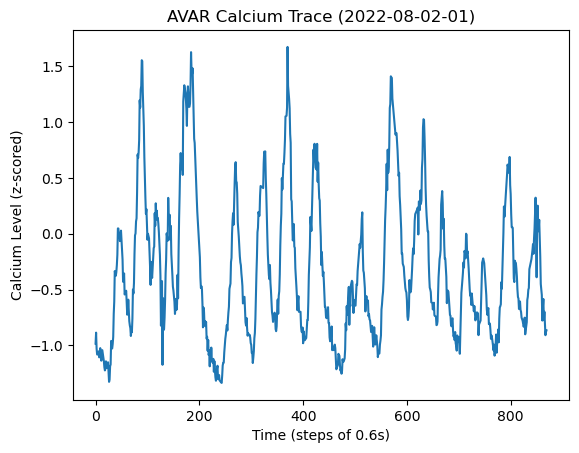

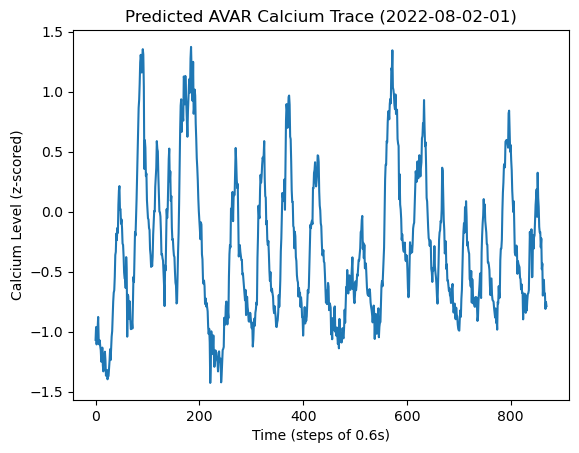

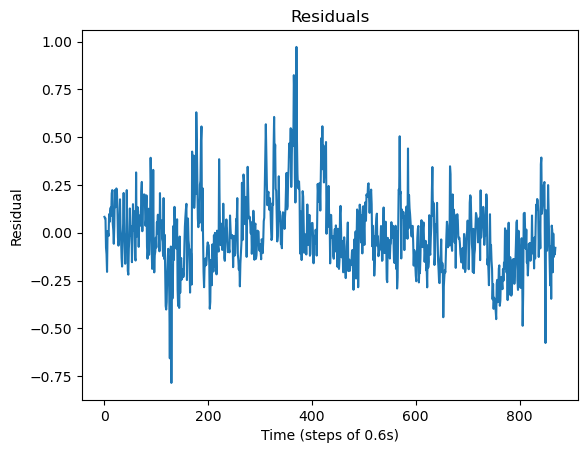

(live_simulation) RMSE: 0.18889741937985682 explained variance: 0.916205068903548
96
[-3.12736006e-02 -2.37579685e-02  1.20131855e-03 -9.41505174e-03
  2.09976899e-02  9.02825654e-03 -2.37242093e-02 -1.04878091e-02
 -2.13267912e-02 -8.82726775e-03 -3.48118148e-03 -9.54847784e-03
 -2.93319985e-02 -4.95748010e-03 -5.00671843e-03  1.92728989e-03
  5.73353741e-04 -2.89308866e-02  3.87660164e-02 -5.82224922e-02
 -3.89495712e-03  4.31857393e-03 -1.25257407e-02  2.54340584e-02
  2.74521774e-02  1.64295689e-02 -7.93418801e-02  9.18753384e-04
 -2.67132922e-02  3.83477250e-01 -2.97592040e-03  1.37476782e-02
  1.82053113e-02  2.59629042e-02  5.77640633e-02  2.44947185e-02
 -6.90480250e-02 -1.66220266e-01  3.31454409e-02  1.20556423e-01
  6.89284060e-03  5.81134938e-01  6.99248982e-03  6.79405919e-03
  8.60998674e-03 -9.98534944e-05  2.12593657e-02  2.59416280e-02
  1.98048764e-02 -9.85350970e-03  1.12219734e-02  9.85684277e-03
  1.07340621e-02  7.61014792e-03  2.96374020e-04 -1.51799099e-02
 -3.8

In [30]:
TEST_NEURON = 'AVAR'

trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
print(f"1 timestep = {trace_obj.trace_json['avg_timestep']*60} seconds")
self_index = trace_obj.get_index(TEST_NEURON)
if self_index == -1:
    raise ValueError(f"Neuron {TEST_NEURON} does not have any labeled traces in this dataset.")

plot_acf(trace_obj.traces[self_index,:], lags=1000)
plt.show()

c = calculate_c(TEST_NEURON, trace_obj, 0, 730)
live_simulation(c, TEST_NEURON, trace_obj, 730)

print(len(c))
print(c)

#### visualize_c

[[-0.0312736   0.00120132  0.02099769]
 [-0.02372421 -0.02132679 -0.00348118]
 [-0.029332   -0.00500672  0.00057335]
 [ 0.03876602 -0.00389496 -0.01252574]
 [ 0.02745218 -0.07934188 -0.02671329]
 [-0.00297592  0.01820531  0.05776406]
 [-0.06904803  0.03314544  0.00689284]
 [ 0.00699249  0.00860999  0.02125937]
 [ 0.01980488  0.01122197  0.01073406]
 [ 0.00029637 -0.03834055 -0.02368356]
 [ 0.01583625 -0.0118666  -0.0015334 ]
 [-0.01166351  0.02680547 -0.03730351]
 [-0.00618156 -0.00199782 -0.0048484 ]
 [-0.03637988  0.0282737   0.0016895 ]
 [-0.00448869  0.01014973 -0.00189382]
 [ 0.00819541  0.00721517  0.0907548 ]]
[[-2.37579685e-02 -9.41505174e-03  9.02825654e-03]
 [-1.04878091e-02 -8.82726775e-03 -9.54847784e-03]
 [-4.95748010e-03  1.92728989e-03 -2.89308866e-02]
 [-5.82224922e-02  4.31857393e-03  2.54340584e-02]
 [ 1.64295689e-02  9.18753384e-04  3.83477250e-01]
 [ 1.37476782e-02  2.59629042e-02  2.44947185e-02]
 [-1.66220266e-01  1.20556423e-01  5.81134938e-01]
 [ 6.79405919e-03 

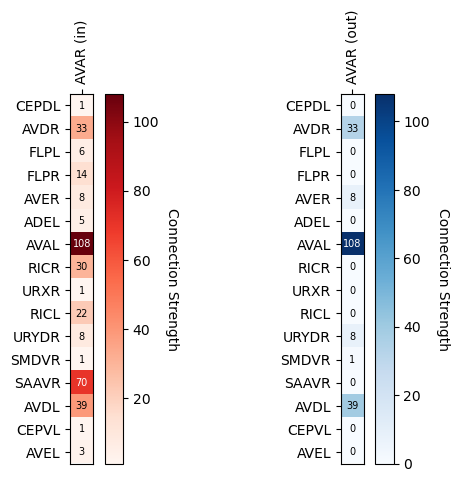

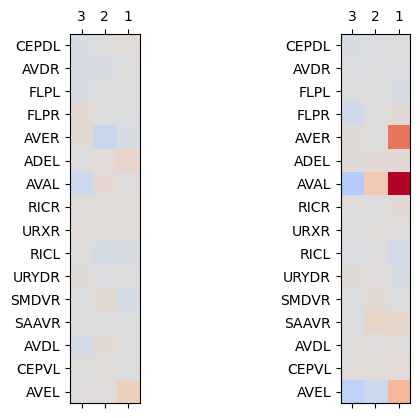

In [31]:
visualize_c(c, TEST_NEURON, trace_obj)

#### convert_c and trace 2

In [32]:
def convert_c(c_1, neuron, trace_obj_1, trace_obj_2, w_rr=W_rr, w_sr=W_sr, connectome=CONNECTOME):
    relevant_mask_1 = get_relevant_mask(neuron, trace_obj_1, connectome)
    relevant_count_1 = np.count_nonzero(relevant_mask_1)
    relevant_labels_1 = get_relevant_mask_labels(neuron, trace_obj_1, connectome)

    relevant_mask_2 = get_relevant_mask(neuron, trace_obj_2, connectome)
    relevant_count_2 = np.count_nonzero(relevant_mask_2)
    relevant_labels_2 = get_relevant_mask_labels(neuron, trace_obj_2, connectome)

    C_1 = np.concatenate((c_1.reshape((relevant_count_1,w_rr,1,w_sr+1)), np.zeros((1,w_rr,1,w_sr+1))))
    perm = [relevant_labels_1.index(label) if label in relevant_labels_1 else -1 for label in relevant_labels_2]
    C_2 = C_1[perm,:,:,:]
    c_2 = C_2.reshape(relevant_count_2*w_rr*(w_sr+1))

    return c_2


/tmp/ipykernel_2589113/2641121574.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c, residuals, rank, singular_values = np.linalg.lstsq(A, observation) # Formula: np.linalg.inv(A.T @ A) @ A.T @ observation


(calculate_c) RMSE: 0.17141587218765966 explained variance: 0.9700132376404147


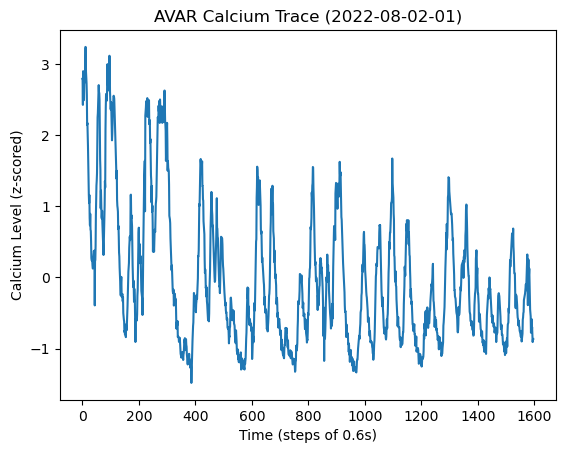

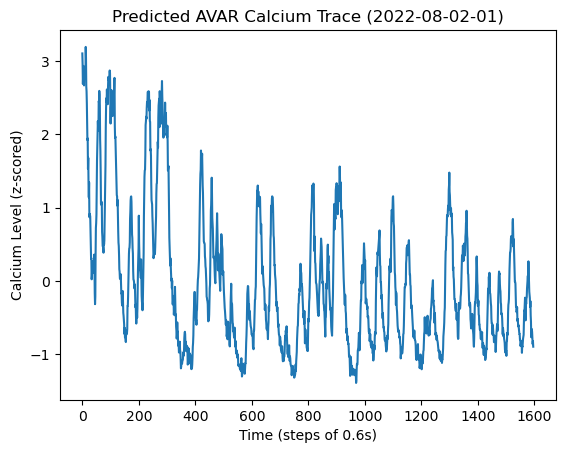

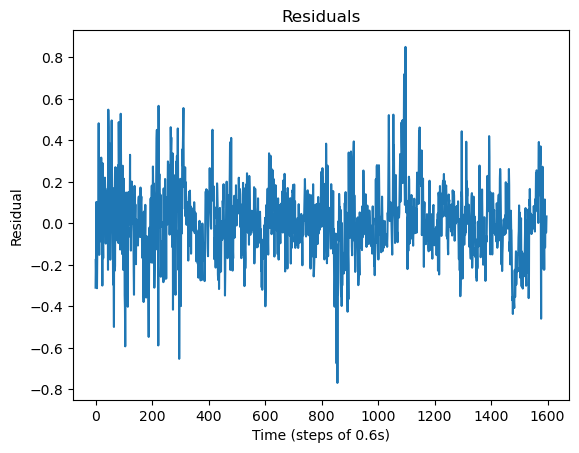

(live_simulation) RMSE: 0.16986890202796115 explained variance: 0.9705520361209672


0.9705520361209672

In [33]:
trace_obj_1 = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
c_1 = calculate_c(TEST_NEURON, trace_obj_1, window_start=0, window_width=1600)
live_simulation(c_1, TEST_NEURON, trace_obj_1)

[[-1.62788291e-02 -6.02867891e-03  1.84927535e-02]
 [-1.11241345e-02 -5.85419350e-03  2.88500281e-03]
 [-2.04135919e-02  1.10178805e-02 -3.20130734e-03]
 [ 1.56906764e-02  1.53698709e-02 -7.14219899e-03]
 [ 5.42097949e-03 -8.37099447e-02 -5.02384761e-02]
 [-2.62682845e-03  1.12163624e-02  2.78912698e-02]
 [-3.49744474e-02 -1.49181934e-02  3.84138197e-02]
 [ 1.59891669e-03  3.45770977e-03  2.09992275e-02]
 [ 4.48336988e-03  3.32099577e-03  1.31922922e-02]
 [ 7.60239364e-05 -2.50175902e-02 -2.54162816e-02]
 [ 1.17492426e-02 -7.09588025e-03  5.01353350e-03]
 [ 2.57015123e-03  1.43670991e-02 -3.27381160e-02]
 [-9.23797368e-03  6.47224535e-03  3.17153783e-03]
 [-3.18438006e-02  1.46718346e-02 -1.38274379e-03]
 [-4.07650736e-03  1.14322684e-02  3.66368661e-03]
 [ 1.99349533e-03  1.21426160e-02  9.84866308e-02]]
[[-1.49842871e-02 -8.00129210e-03  3.68356176e-03]
 [-2.94382603e-03 -1.52914124e-04  8.57437232e-03]
 [-2.02117549e-02 -3.48646727e-03 -1.63179839e-02]
 [-2.14041783e-02 -2.46111920e

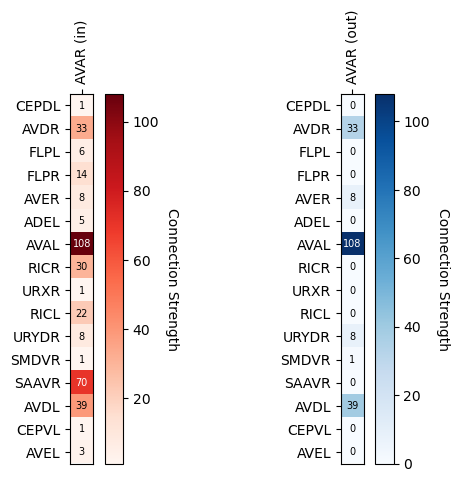

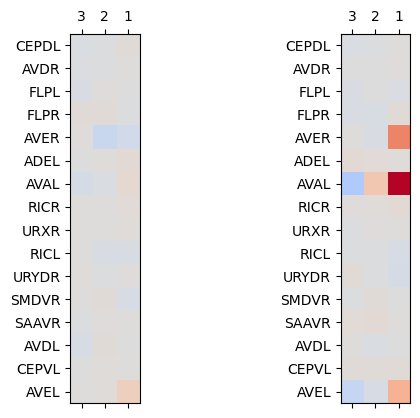

In [34]:
visualize_c(c_1, TEST_NEURON, trace_obj_1)

[[ 1.99349533e-03  1.21426160e-02  9.84866308e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.48336988e-03  3.32099577e-03  1.31922922e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.17492426e-02 -7.09588025e-03  5.01353350e-03]
 [-2.62682845e-03  1.12163624e-02  2.78912698e-02]
 [ 7.60239364e-05 -2.50175902e-02 -2.54162816e-02]
 [ 1.56906764e-02  1.53698709e-02 -7.14219899e-03]
 [-3.49744474e-02 -1.49181934e-02  3.84138197e-02]
 [ 5.42097949e-03 -8.37099447e-02 -5.02384761e-02]
 [-1.62788291e-02 -6.02867891e-03  1.84927535e-02]
 [-1.11241345e-02 -5.85419350e-03  2.88500281e-03]
 [-2.04135919e-02  1.10178805e-02 -3.20130734e-03]
 [ 1.59891669e-03  3.45770977e-03  2.09992275e-02]
 [-4.07650736e-03  1.14322684e-02  3.66368661e-03]
 [-3.18438006e-02  1.46718346e-02 -1.38274379e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
[[-1.03929454e-01 -3.24291733e-02  2.19547674e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-5.16201346e-03  4.79681864e

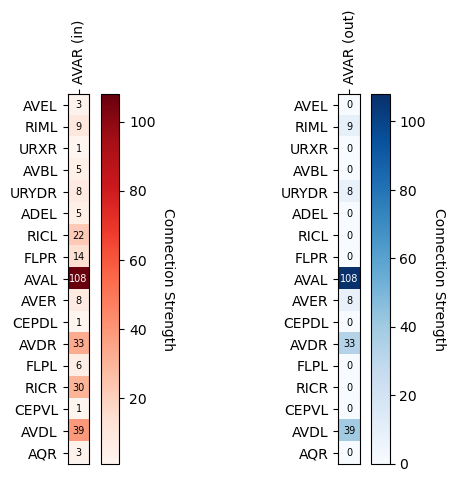

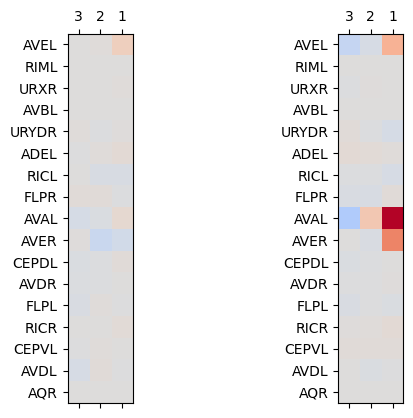

In [35]:
trace_obj_2 = TraceObject('datasets/wormwideweb/2023-01-23-15.json')
c_2 = convert_c(c_1, TEST_NEURON, trace_obj_1, trace_obj_2)
visualize_c(c_2, TEST_NEURON, trace_obj_2)

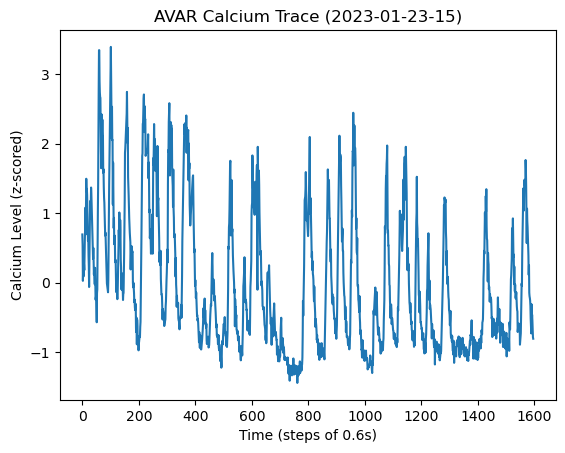

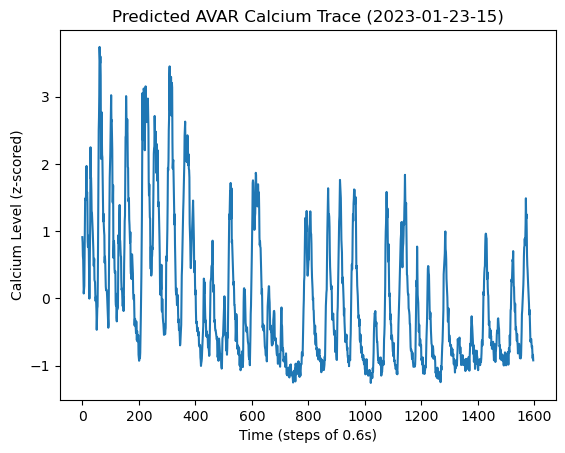

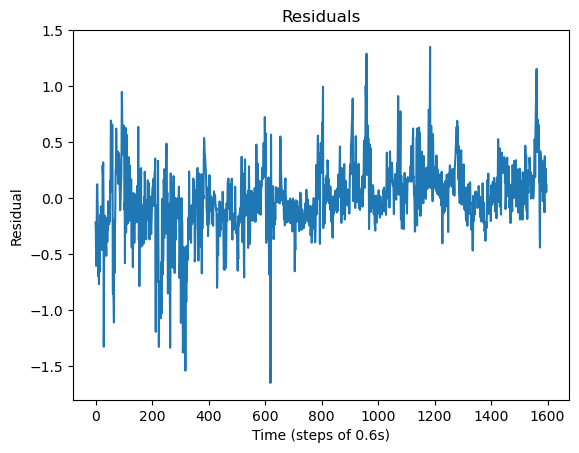

(live_simulation) RMSE: 0.3165736279728441 explained variance: 0.8997770219568312


0.8997770219568312

In [36]:
live_simulation(c_2, TEST_NEURON, trace_obj_2)

#### Automating w_rr and w_sr finding

/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metrics/_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/u/ronakr/installations/envs/worms/lib/python3.11/site-packages/sklearn/metr

AVAR
[[ 0.00916381]
 [-0.02415692]
 [-0.02929235]
 [-0.0009741 ]
 [-0.08653722]
 [ 0.06764573]
 [-0.02419028]
 [ 0.024447  ]
 [ 0.02019663]
 [-0.02790786]
 [ 0.01437881]
 [-0.0243263 ]
 [-0.00420467]
 [-0.00611053]
 [ 0.00236118]
 [ 0.09661775]]
[[-0.00398819]
 [-0.02297205]
 [-0.04185271]
 [ 0.00664209]
 [ 0.31385581]
 [ 0.07223645]
 [ 0.5393757 ]
 [ 0.03165951]
 [ 0.00470709]
 [-0.05562399]
 [-0.01539302]
 [-0.00896022]
 [ 0.07373331]
 [ 0.01533915]
 [ 0.03174583]
 [ 0.12301274]]
AVAL
[[ 2.35041141e-02]
 [-5.62792505e-04]
 [ 4.28760869e-02]
 [-2.66974229e-03]
 [ 1.01393474e+00]
 [-6.13962652e-03]
 [ 1.32751557e-02]
 [-4.15150387e-02]
 [ 9.30200833e-02]
 [ 1.72017544e-02]
 [-3.79126856e-02]]
AVER
[[ 2.11922903e-02  1.31837265e-04 -1.17807285e-02  8.02271901e-03
  -2.66929165e-02 -7.06057201e-03  2.30874167e-04  1.47087058e-02
   2.28440120e-02]
 [ 4.67496979e-03  5.61214887e-03  3.08655460e-02  4.21916897e-03
   4.63887898e-03 -1.56970628e-02  5.60190199e-03 -9.53931929e-03
  -1.62701

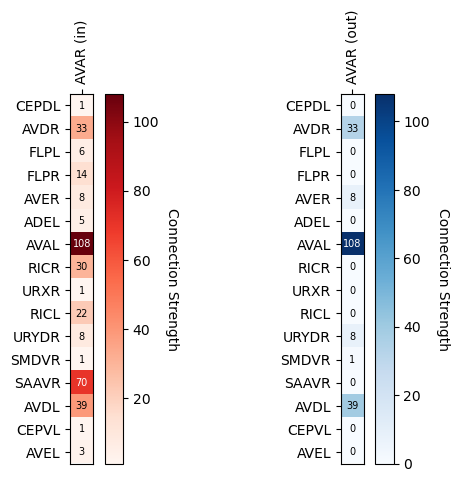

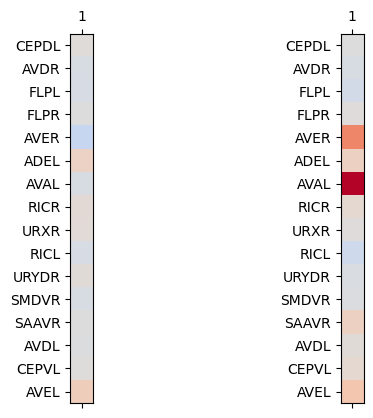

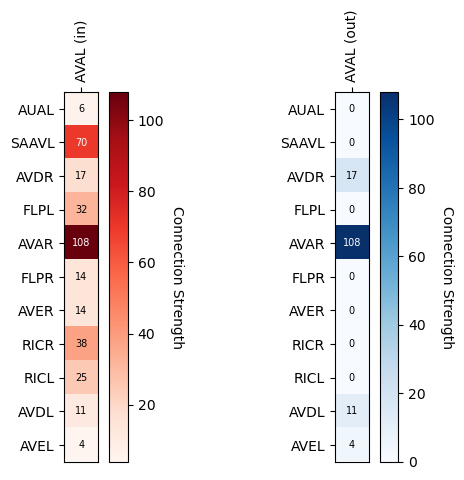

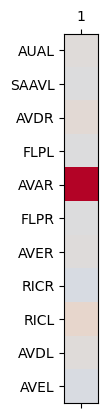

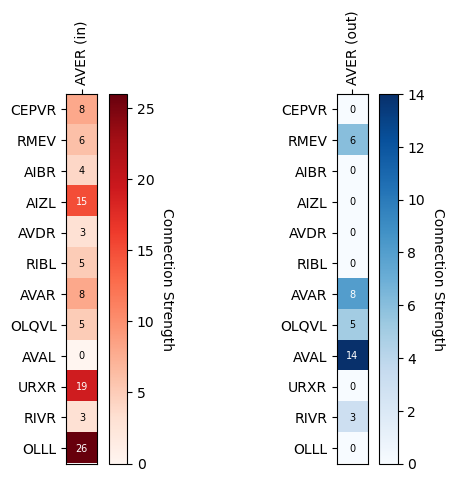

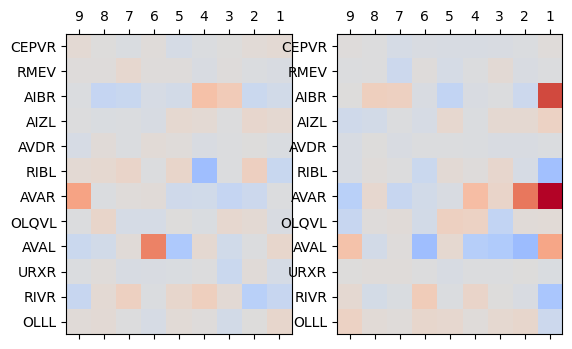

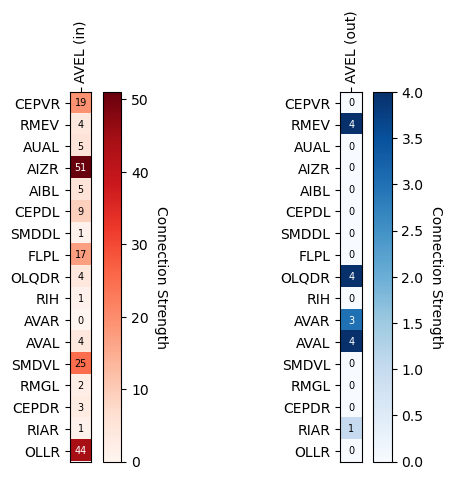

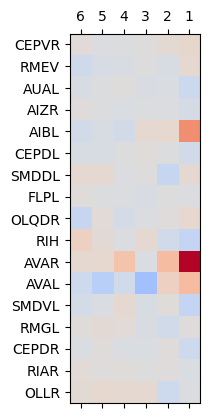

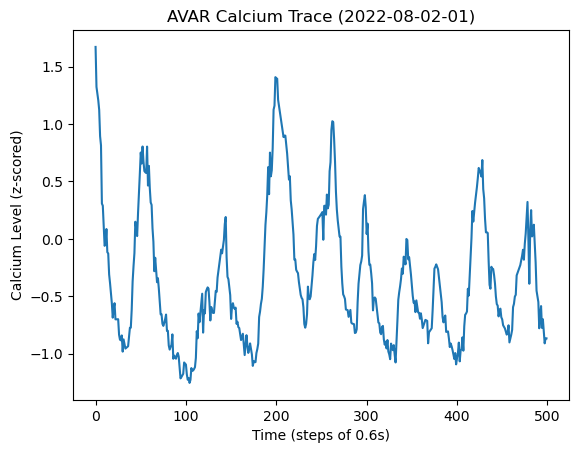

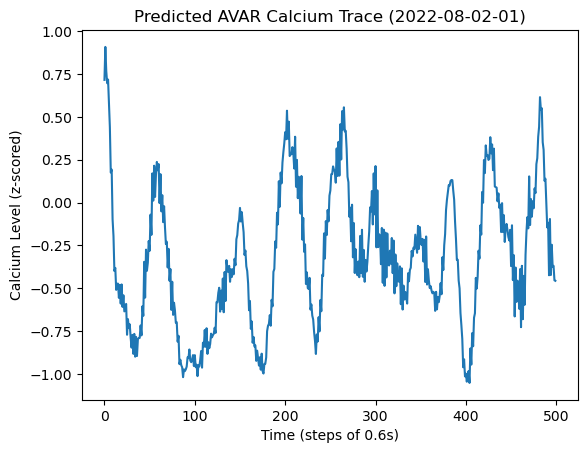

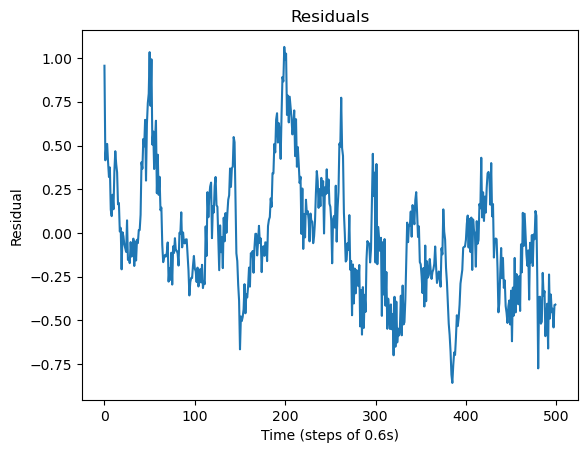

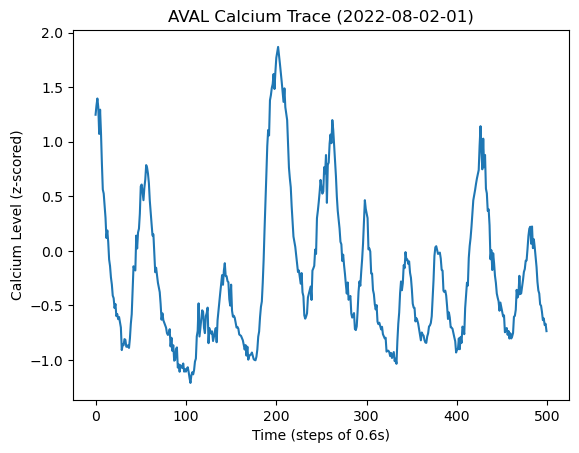

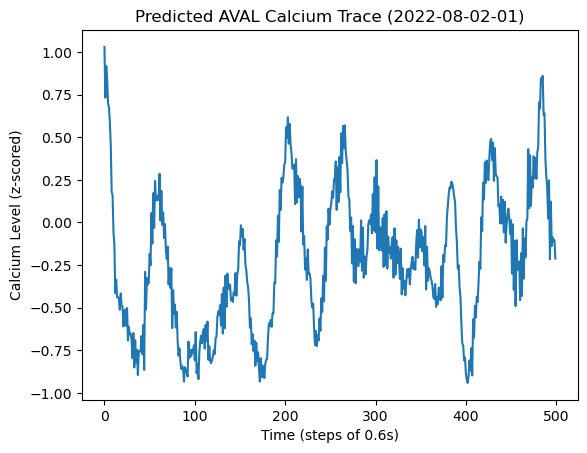

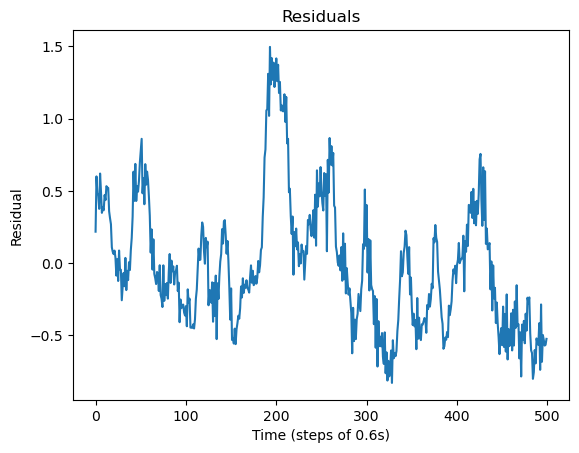

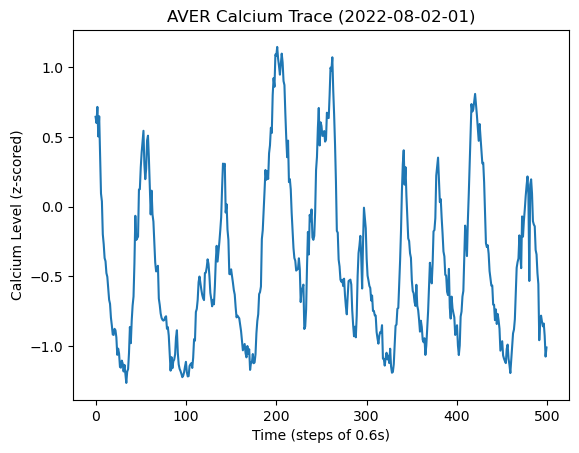

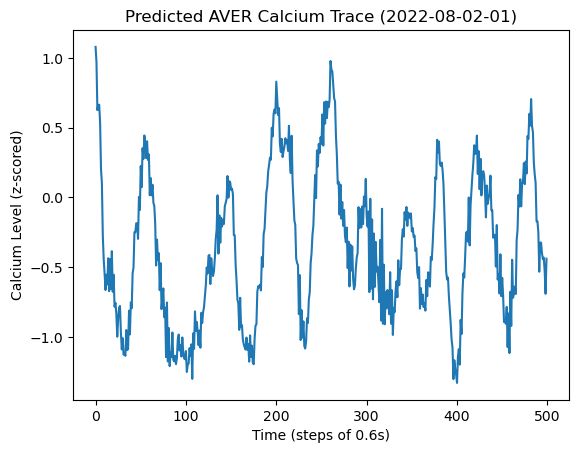

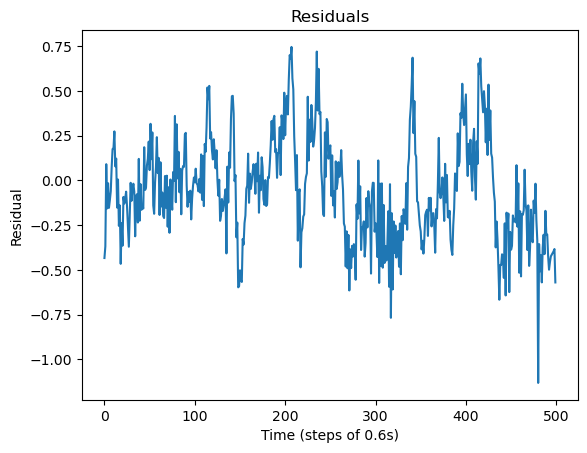

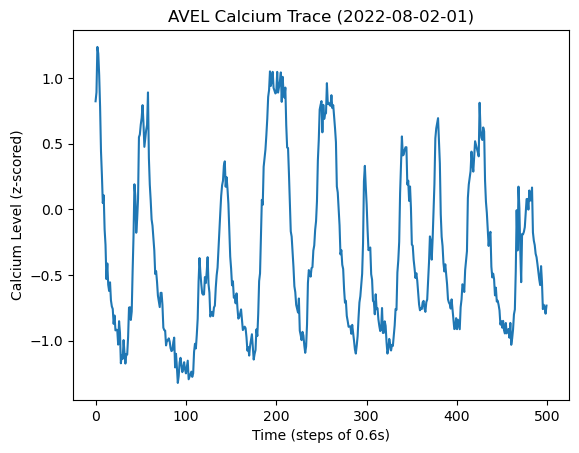

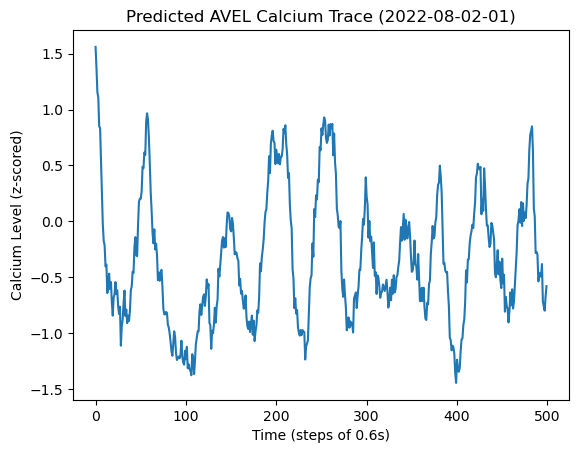

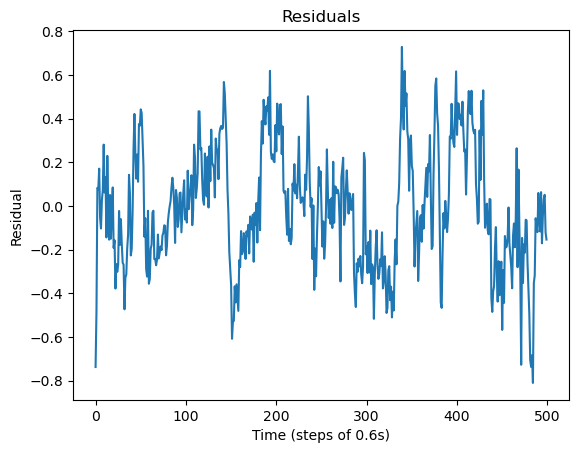

(live_simulations) RMSE: 0.3473903563583987 explained variance: 0.6851660005872222


0.6851660005872222

In [55]:
trace_obj_1 = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
neuron_arr = ['AVAR', 'AVAL', 'AVER', 'AVEL']
final_c_values = {}
for neuron in neuron_arr:
    candidates = []
    for w_rr in range(1,20):
        for w_sr in range(0,3):
            c = 0
            expl_var = 0
            try:
                c = calculate_c(neuron, trace_obj_1, window_start=0, window_width=800, w_rr=w_rr, w_sr=w_sr, plot=False)
                expl_var = live_simulation(c, neuron, trace_obj_1, start=1100, runtime=500, w_rr=w_rr, w_sr=w_sr, plot=False)
            except Exception:
                pass
            candidates.append((expl_var, (w_rr, w_sr, c)))
    final_c_values[neuron] = max(candidates)[1]

neurons = []
for neuron in final_c_values:
    print(neuron)
    w_rr, w_sr, c = final_c_values[neuron]
    neurons.append(NeuronParam(neuron, w_rr, w_sr, c, trace_obj_1))
    visualize_c(c, neuron, trace_obj_1, w_rr=w_rr, w_sr=w_sr)

live_simulations(neurons, trace_obj_1, start=1100, runtime=500, plot=True)

#### predicting trace 2

[[ 0.09661775]
 [ 0.        ]
 [ 0.02019663]
 [ 0.        ]
 [ 0.01437881]
 [ 0.06764573]
 [-0.02790786]
 [-0.0009741 ]
 [-0.02419028]
 [-0.08653722]
 [ 0.00916381]
 [-0.02415692]
 [-0.02929235]
 [ 0.024447  ]
 [ 0.00236118]
 [-0.00611053]
 [ 0.        ]]
[[ 0.12301274]
 [ 0.        ]
 [ 0.00470709]
 [ 0.        ]
 [-0.01539302]
 [ 0.07223645]
 [-0.05562399]
 [ 0.00664209]
 [ 0.5393757 ]
 [ 0.31385581]
 [-0.00398819]
 [-0.02297205]
 [-0.04185271]
 [ 0.03165951]
 [ 0.03174583]
 [ 0.01533915]
 [ 0.        ]]
[[-3.79126856e-02]
 [-5.62792505e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 9.30200833e-02]
 [-6.13962652e-03]
 [ 1.01393474e+00]
 [ 1.32751557e-02]
 [ 4.28760869e-02]
 [-2.66974229e-03]
 [-4.15150387e-02]
 [ 1.72017544e-02]
 [ 0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.29828604e-03 -7.07218076e-02 -6.31325311e-02 -2.13337331e-02
  -3.28858580e-02  1.16

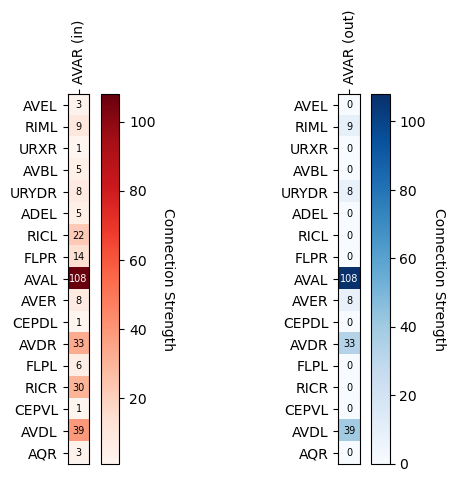

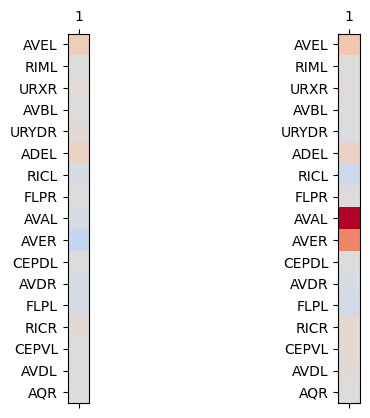

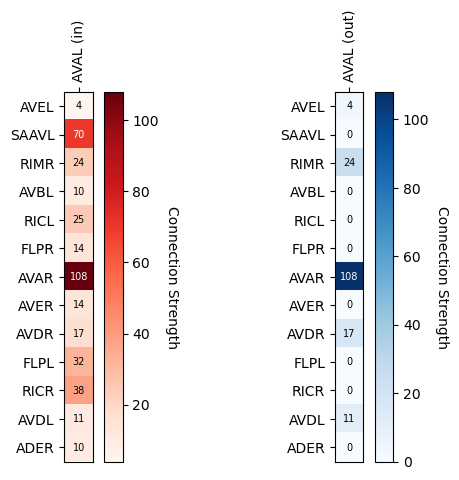

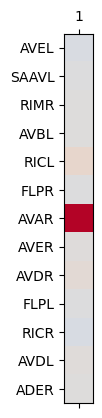

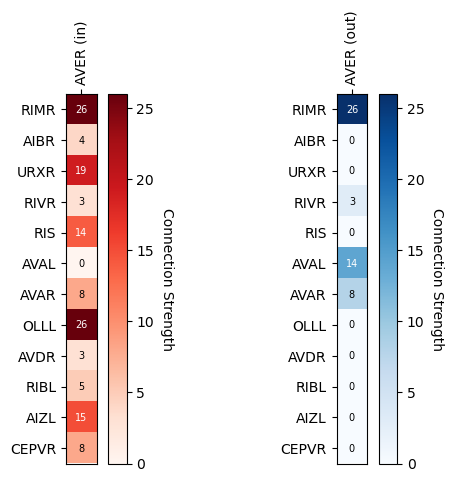

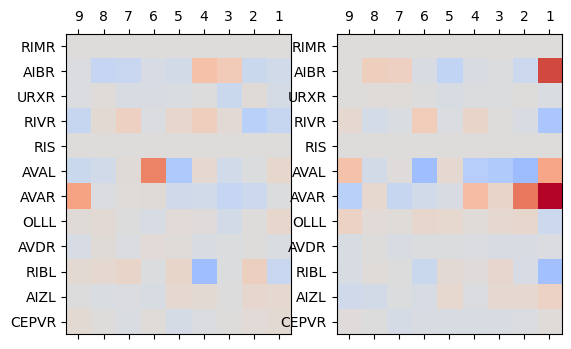

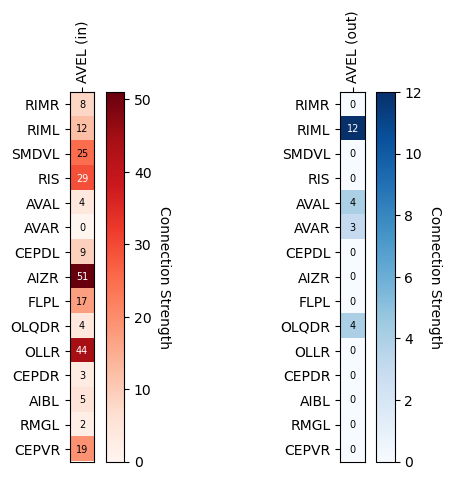

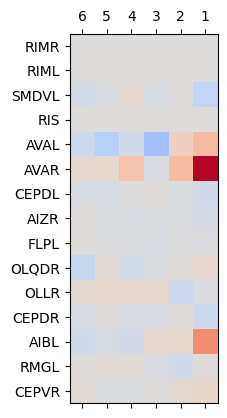

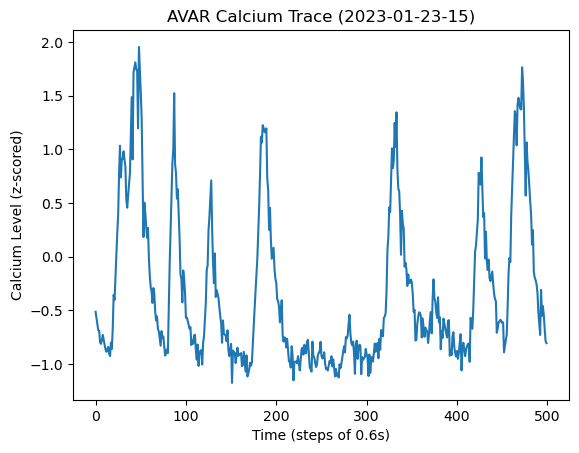

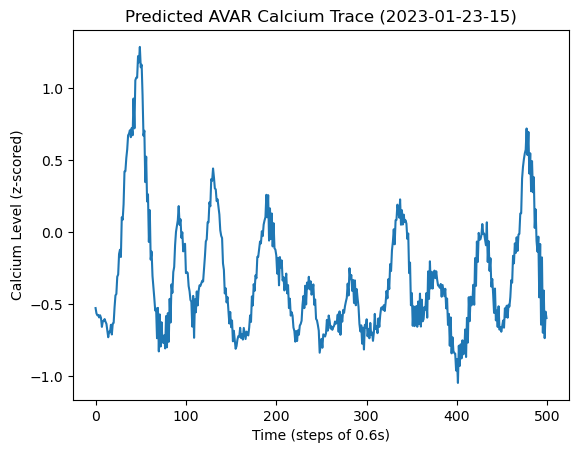

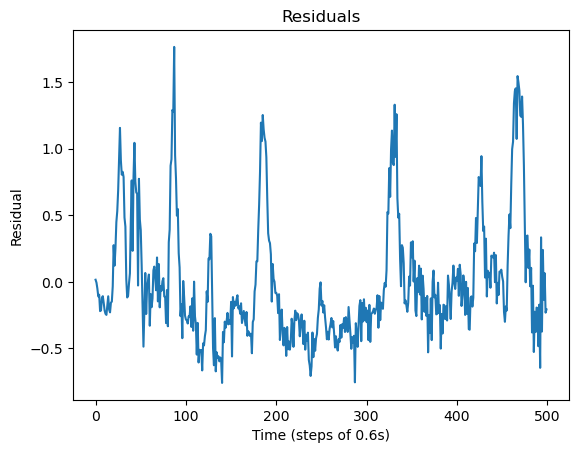

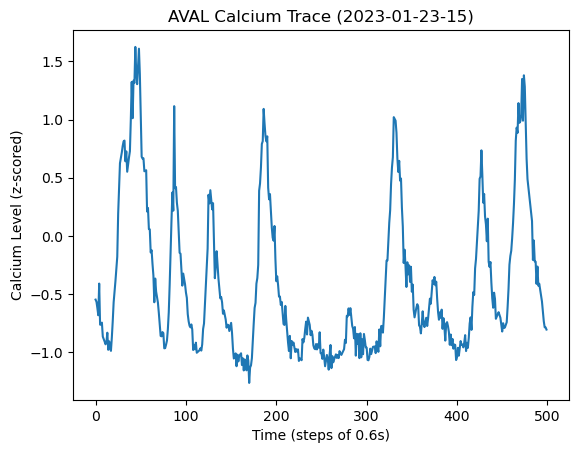

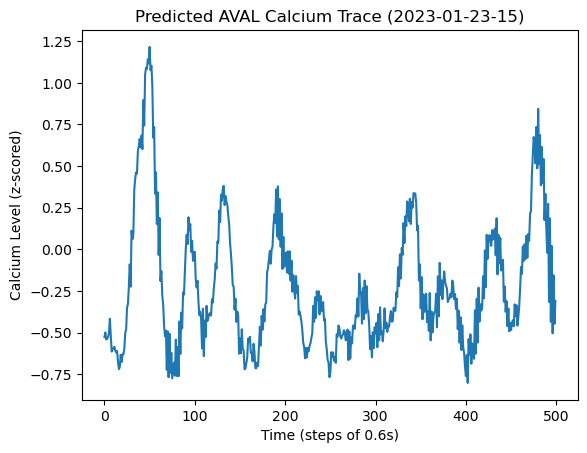

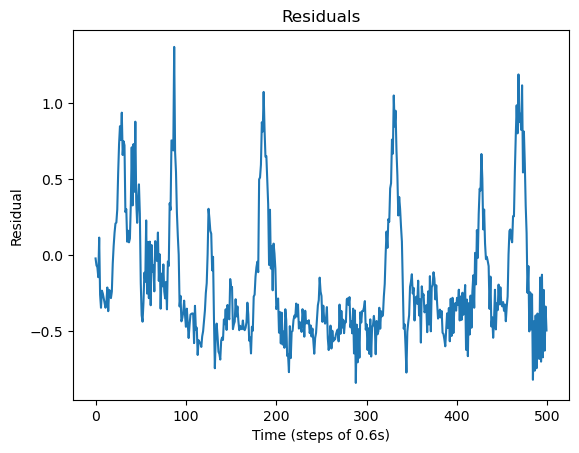

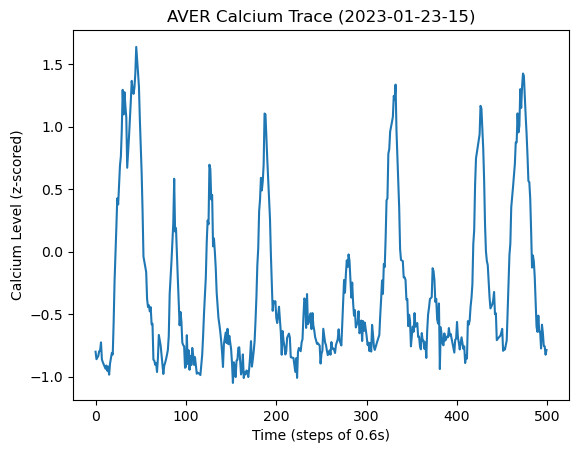

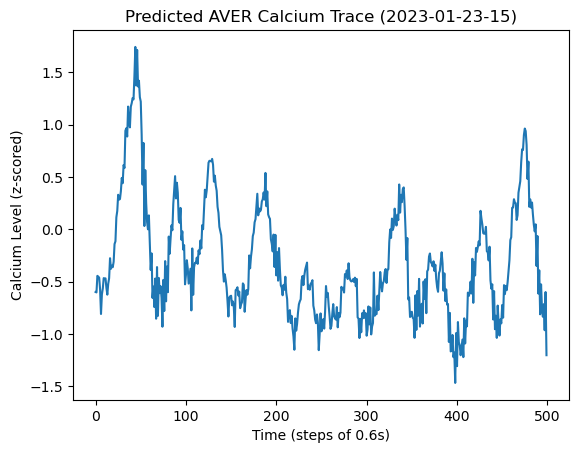

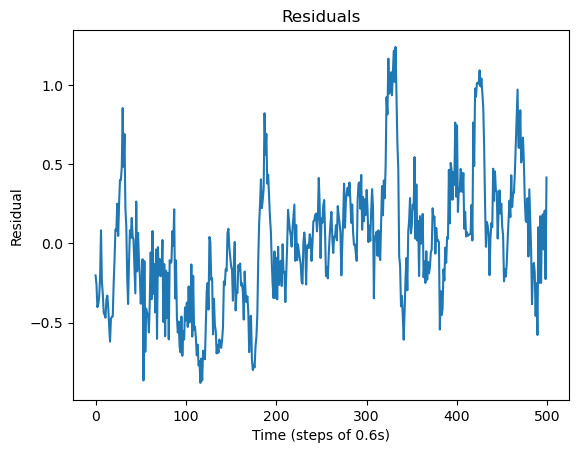

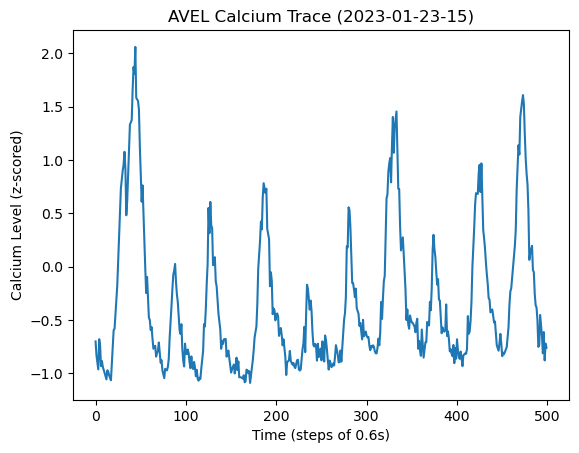

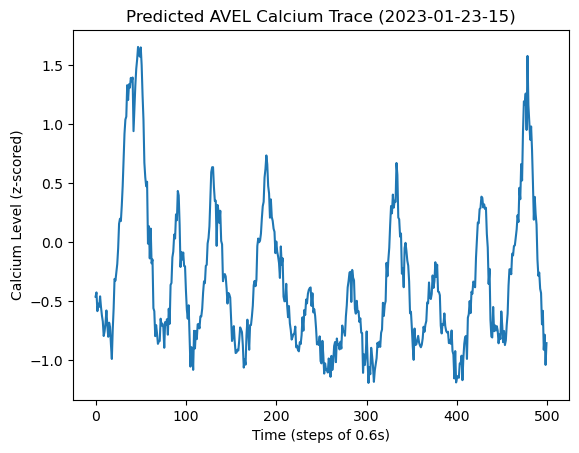

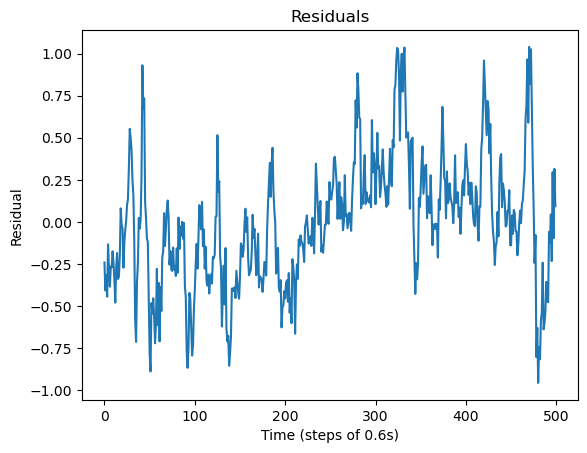

(live_simulations) RMSE: 0.42256428626342635 explained variance: 0.6058655386112515


0.6058655386112515

In [56]:
trace_obj_2 = TraceObject('datasets/wormwideweb/2023-01-23-15.json')
neurons_2 = []
for neuron in neurons:
    c_2 = convert_c(neuron.c, neuron.label, trace_obj_1=trace_obj_1, trace_obj_2=trace_obj_2, w_rr=neuron.w_rr, w_sr=neuron.w_sr)
    neurons_2.append(NeuronParam(neuron.label, neuron.w_rr, neuron.w_sr, c_2, trace_obj_2))
    visualize_c(c_2, neuron.label, trace_obj_2, w_rr=neuron.w_rr, w_sr=neuron.w_sr)

live_simulations(neurons_2, trace_obj_2, start=1100, runtime=500, plot=True)

In [39]:
a = [(3,'djhd'), (1,'eureui'), (5,'dure')]
print(min(a))

(1, 'eureui')


### ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 274.307
Date:                Thu, 09 Nov 2023   AIC                           -536.614
Time:                        23:47:19   BIC                           -509.064
Sample:                             0   HQIC                          -525.984
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      0.028      1.444      0.149      -0.014       0.094
ar.L2          0.1629      0.038      4.269      0.000       0.088       0.238
ar.L3          0.1420      0.037      3.799      0.0

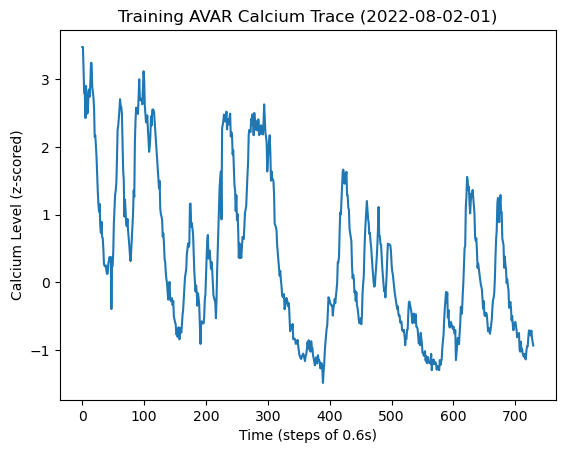

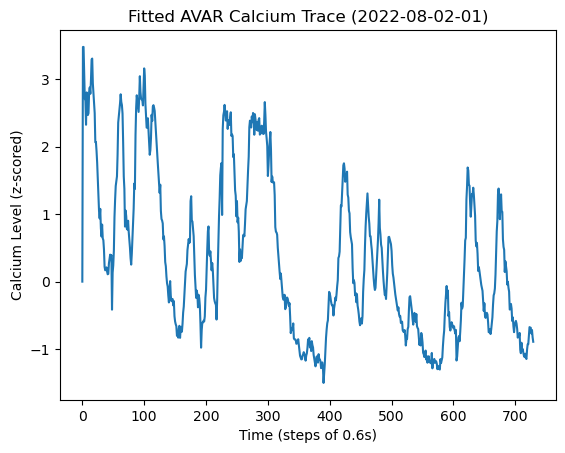

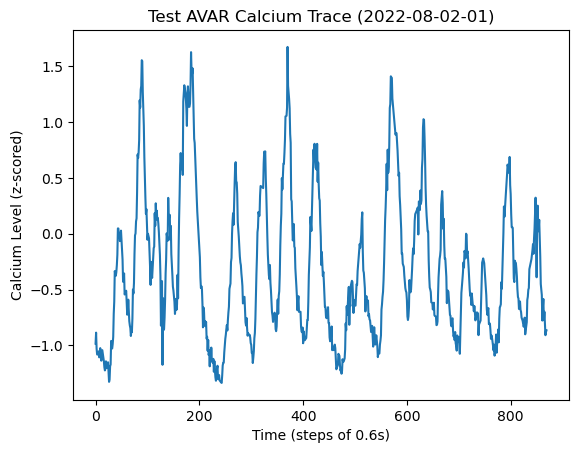

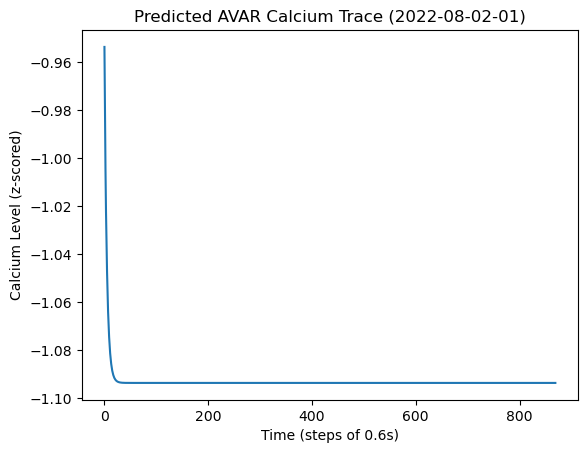

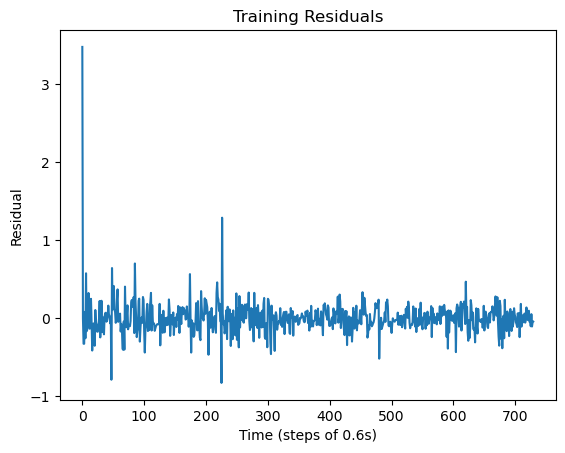

                0
count  730.000000
mean     0.001739
std      0.210123
min     -0.826684
25%     -0.088428
50%     -0.007717
75%      0.087777
max      3.474439


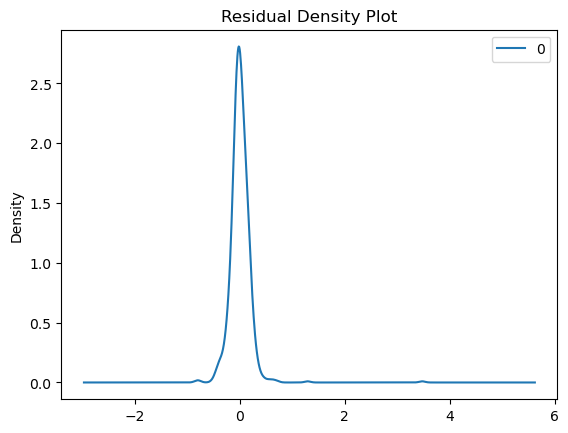

In [40]:
trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
self_index = trace_obj.get_index(TEST_NEURON)

train = trace_obj.traces[self_index,:730]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

fit = model_fit.fittedvalues
test = trace_obj.traces[self_index,730:]
preds = model_fit.forecast(len(trace_obj.traces[self_index])-730)
residuals = DataFrame(model_fit.resid)

# summary of fit model
print(model_fit.summary())

# RMSE
print("Fitted RMSE: %.3f" % np.sqrt(mean_squared_error(train, fit)), "explained variance:", 1 - (mean_squared_error(train, fit))/np.var(train))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)), "explained variance:", 1 - (mean_squared_error(train, fit))/np.var(train))

# == Fit ==
plot_trace(train, title=f"Training {TEST_NEURON} Calcium Trace ({trace_obj.uid})")
plot_trace(fit, title=f"Fitted {TEST_NEURON} Calcium Trace ({trace_obj.uid})")

# == Forecast ==
plot_trace(test, title=f"Test {TEST_NEURON} Calcium Trace ({trace_obj.uid})")
plot_trace(preds, title=f"Predicted {TEST_NEURON} Calcium Trace ({trace_obj.uid})")

# == residuals ==
plot_trace(residuals,  title="Training Residuals", ylabel="Residual")

# == density plot of residuals ==
residuals.plot(title="Residual Density Plot", kind='kde')

# summary stats of residuals
print(residuals.describe())

In [41]:
train, test = pm.model_selection.train_test_split(trace_obj.traces[self_index,:], train_size=730)
model = pm.auto_arima(train, 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic


 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1879.757, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2333.488, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1167.070, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2400.426, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1472.557, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1085.106, Time=0.50 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1084.065, Time=0.22 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1085.428, Time=0.61 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1883.280, Time=0.14 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-472.912, Time=0.68 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-474.844, Time=0.27 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-472.917, Time=0.60 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-470.844, Time=1.25 sec
 ARIM

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 274.307
Date:                Thu, 09 Nov 2023   AIC                           -536.614
Time:                        23:48:13   BIC                           -509.064
Sample:                             0   HQIC                          -525.984
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0397      0.028      1.444      0.149      -0.014       0.094
ar.L2          0.1629      0.038      4.269      0.000       0.088       0.238
ar.L3          0.1420      0.037      3.799      0.0

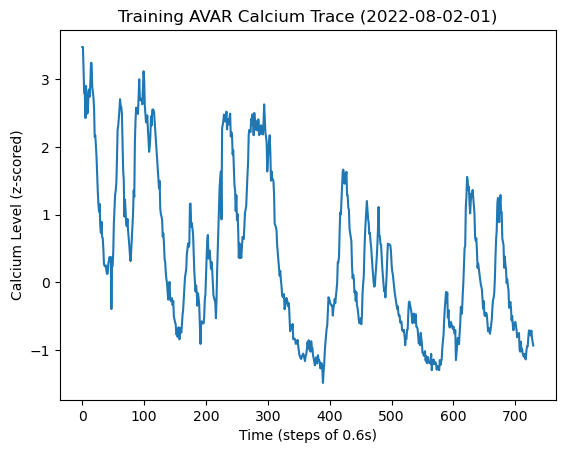

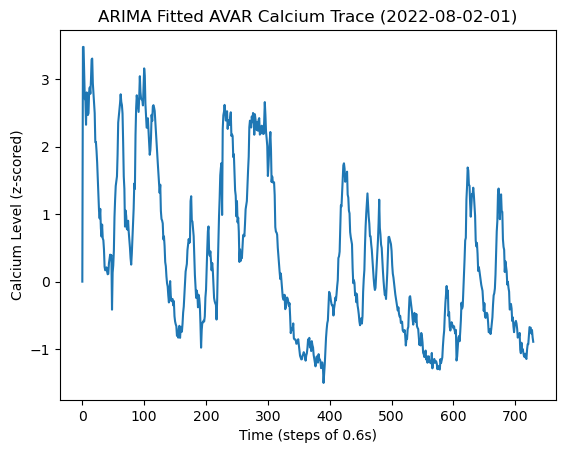

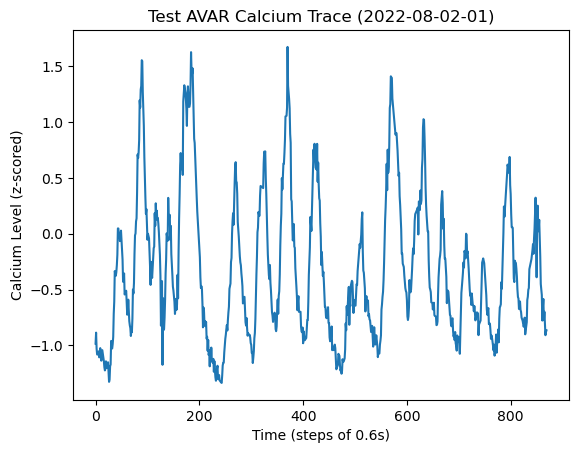

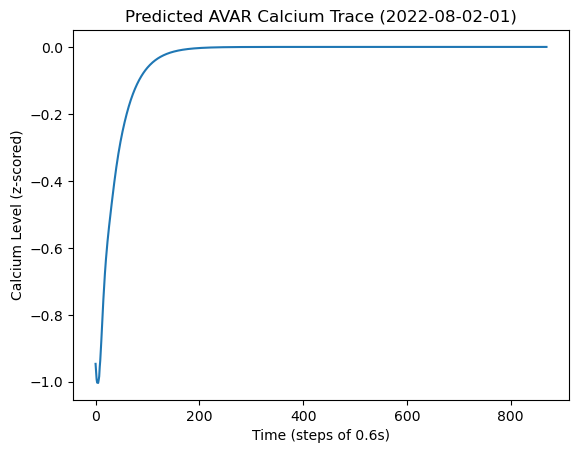

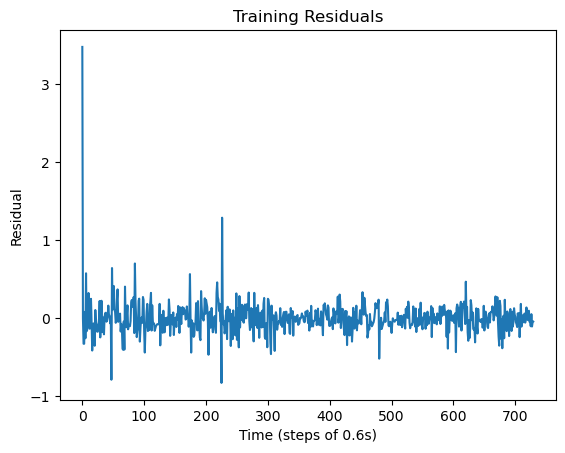

                0
count  730.000000
mean     0.001739
std      0.210123
min     -0.826684
25%     -0.088428
50%     -0.007717
75%      0.087777
max      3.474439


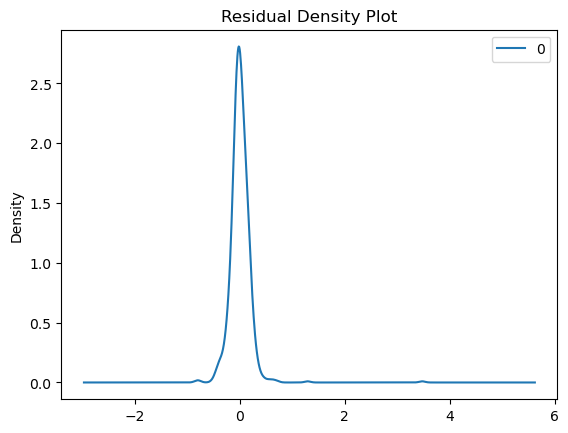

In [42]:
# print("Fitted RMSE: %.3f" % np.sqrt(mean_squared_error(train, fit)), "explained variance:", 1 - (mean_squared_error(train, fit))/np.var(train))
# print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)), "explained variance:", 1 - (mean_squared_error(test, preds))/np.var(test))

fit = model_fit.fittedvalues
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

# summary of fit model
print(model_fit.summary())

# RMSE
print("Fitted RMSE: %.3f" % np.sqrt(mean_squared_error(train, fit)))
print("explained variance:", 1 - (mean_squared_error(train, fit)/np.var(train)))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))
print(mean_squared_error(test, preds), np.var(test))
print("explained variance:", 1 - (mean_squared_error(test, preds)/np.var(test)))

# == Fit ==
plot_trace(train, title=f"Training {TEST_NEURON} Calcium Trace ({trace_obj.uid})")
plot_trace(fit, title=f"ARIMA Fitted {TEST_NEURON} Calcium Trace ({trace_obj.uid})")

# == Forecast ==
plot_trace(test, title=f"Test {TEST_NEURON} Calcium Trace ({trace_obj.uid})")
plot_trace(preds, title=f"Predicted {TEST_NEURON} Calcium Trace ({trace_obj.uid})")

# == residuals ==
plot_trace(residuals,  title="Training Residuals", ylabel="Residual")

# == density plot of residuals ==
residuals.plot(title="Residual Density Plot", kind='kde')

# summary stats of residuals
print(residuals.describe())

TODO notes: 
- create new object for trace-specific neuron info, turn neuron params into just the neuron, w_rr/w_sr, and C (with labels).
- make connectome global? Want to be able to swap in fake one (or future organisms) so no
- make experiment object with table of traces, connectome, and neuron params? might be a good idea.